In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tinygrad import Tensor, nn, TinyJit
import numpy as np
from common import word_generator, create_transition_matrix, draw_transition_matrix
from functools import reduce

In [3]:
names = open("./names.txt").read().splitlines()

In [4]:
empty_char_token = "."
vocab = [empty_char_token] + sorted(set("".join(names)))
vocab_size = len(vocab)

In [5]:
block_size = 4
X, y = [], []

for name in names:
  name_chars = [empty_char_token] * block_size + list(name) + [empty_char_token]
  for i in range(len(name_chars) - block_size):
    X.append([vocab.index(char) for char in name_chars[i : i + block_size]])
    y.append(vocab.index(name_chars[i + block_size]))


split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = (
  Tensor(X[:split]),
  Tensor(y[:split]),
  Tensor(X[split:]),
  Tensor(y[split:]),
)

X_train, y_train, X_test, y_test

(<Tensor <LB CLANG (182516, 4) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (182516,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630, 4) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>)

In [39]:
class EmbeddedMLP:
  def __init__(
    self,
    vocab_size,
    embed_size,
    input_size,
    output_size,
    h=[(200, Tensor.relu), (100, Tensor.relu)],
  ):
    self.input_size = input_size
    self.layers = [nn.Embedding(vocab_size, embed_size)]
    flattened_embed_size = input_size * embed_size
    self.layers.append(lambda x: x.reshape((-1, flattened_embed_size)))
    prev_layer_size = flattened_embed_size
    for layer_size, layer_activation in h:
      self.layers.append(nn.Linear(prev_layer_size, layer_size))
      self.layers.append(nn.BatchNorm(layer_size))
      self.layers.append(layer_activation)
      prev_layer_size = layer_size
    self.layers.append(nn.Linear(prev_layer_size, output_size))

  def __call__(self, x: Tensor):
    assert len(x.shape) <= 2 and x.shape[-1] == self.input_size
    return x.sequential(self.layers)


embedded_mlp = EmbeddedMLP(
  vocab_size, embed_size=10, input_size=block_size, output_size=vocab_size
)

In [40]:
optim = nn.optim.Adam(nn.state.get_parameters(embedded_mlp))
batch_size = 128


@TinyJit
@Tensor.train()
def train_step():
  optim.zero_grad()
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X_samples, y_samples = X_train[samples], y_train[samples]
  loss = embedded_mlp(X_samples).sparse_categorical_crossentropy(y_samples).backward()
  optim.step()
  return loss

In [41]:
for step in range(1, 20001):
  loss = train_step()
  if step == 1 or step % 1000 == 0:
    Tensor.training = False
    acc = (embedded_mlp(X_test).argmax(axis=1) == y_test).mean().item()
    print(f"step {step}, loss {loss.item():.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.39, acc 1.48%
step 1000, loss 2.18, acc 27.66%
step 2000, loss 2.11, acc 28.33%
step 3000, loss 1.85, acc 29.45%
step 4000, loss 1.98, acc 29.20%
step 5000, loss 1.90, acc 28.84%
step 6000, loss 2.14, acc 29.96%
step 7000, loss 2.14, acc 29.50%
step 8000, loss 2.04, acc 30.52%
step 9000, loss 1.94, acc 30.33%
step 10000, loss 1.99, acc 30.46%
step 11000, loss 1.95, acc 30.63%
step 12000, loss 2.03, acc 30.64%
step 13000, loss 1.97, acc 30.45%
step 14000, loss 2.04, acc 30.49%
step 15000, loss 1.95, acc 30.48%
step 16000, loss 1.83, acc 30.91%
step 17000, loss 2.02, acc 30.99%
step 18000, loss 2.04, acc 30.73%
step 19000, loss 1.91, acc 30.59%
step 20000, loss 1.95, acc 30.67%


In [48]:
@word_generator(
  block_size=block_size, empty_char=empty_char_token, max_size=float("inf")
)
def generate_word(prev_block: str):
  x = Tensor([vocab.index(char) for char in prev_block])
  y = embedded_mlp(x).squeeze()
  counts = y.exp()
  p = counts / counts.sum()
  return np.random.choice(a=vocab, p=p.numpy())

In [49]:
generated_names = []
for _ in range(32000):
  generated_names.append(generate_word())

generated_names[:1000]

['daxton',
 'laia',
 'mayah',
 'rauilea',
 'seytyn',
 'arelynn',
 'misha',
 'hairah',
 'paitli',
 'anne',
 'luan',
 'sire',
 'giovanna',
 'shan',
 'laimree',
 'estinila',
 'norlai',
 'mahavy',
 'ryley',
 'losen',
 'yaniel',
 'adio',
 'tino',
 'evorosa',
 'mery',
 'kenja',
 'claira',
 'ryker',
 'artlan',
 'balii',
 'yaan',
 'jaco',
 'wilson',
 'taliyah',
 'jeyannah',
 'gvadie',
 'amaris',
 'blyten',
 'lillie',
 'raelee',
 'vall',
 'berge',
 'arwynn',
 'creilyn',
 'renne',
 'mirce',
 'syri',
 'shah',
 'jsei',
 'tyrellamaya',
 'camille',
 'vontanon',
 'islei',
 'debarth',
 'elifan',
 'emmera',
 'shai',
 'aslai',
 'aneela',
 'ryken',
 'nari',
 'vearc',
 'marioseal',
 'trigan',
 'wyllee',
 'race',
 'romeesh',
 'saminad',
 'cherick',
 'kenzi',
 'imri',
 'nora',
 'ahmaan',
 'lour',
 'kaylie',
 'logga',
 'werdhi',
 'zylee',
 'khalim',
 'garie',
 'camrie',
 'analaya',
 'stella',
 'frandi',
 'jazzie',
 'sher',
 'avya',
 'nasaah',
 'brooklin',
 'jarelimae',
 'whit',
 'kelai',
 'fishon',
 'nicke',

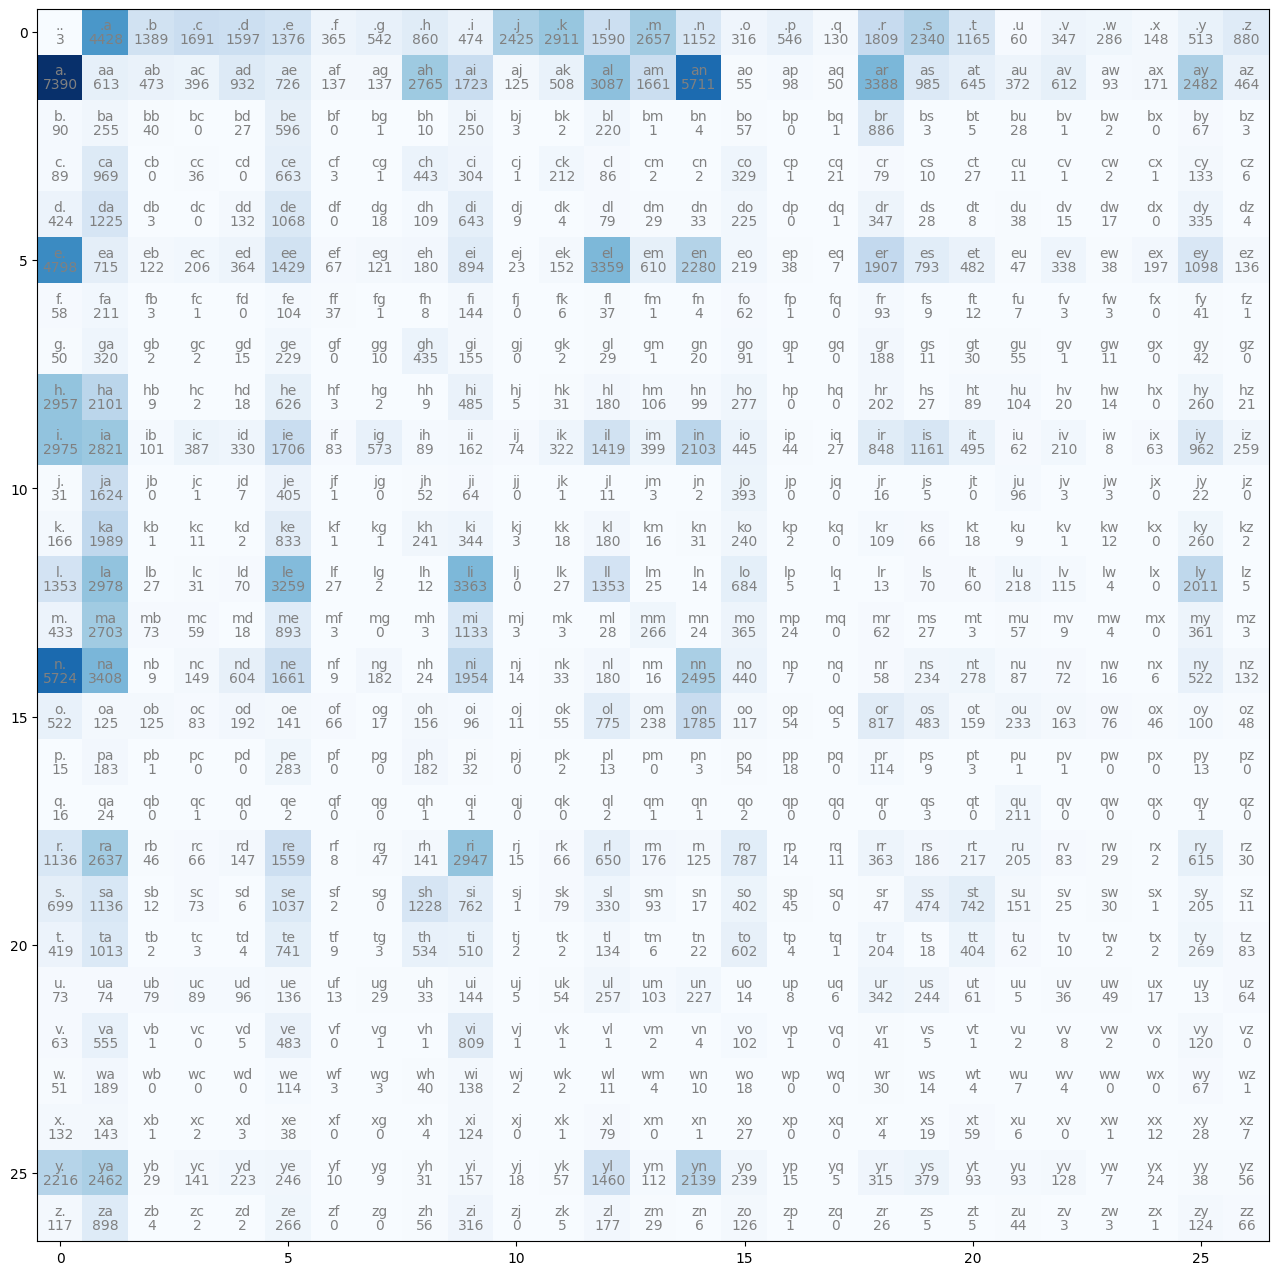

In [50]:
draw_transition_matrix(
  create_transition_matrix(generated_names, vocab, empty_char_token), vocab
)